In [1]:
#!/usr/bin/python
import nltk
import numpy as np
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from random import randint
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import itertools
from nltk.stem.wordnet import WordNetLemmatizer 
from collections import namedtuple
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

Importing Glove and  40000 words list 

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')
print(len(wordsList))
print(wordVectors.shape)
print(wordsList[5066])
print(wordVectors[5066][:])

Loaded the word list!
Loaded the word vectors!
400000
(400000, 50)
closure
[ 0.50653   0.12284  -0.11653  -0.21052  -1.0672   -0.17536   0.16253
  0.76781   0.25517  -0.15995   0.025424 -0.65425  -0.44638  -0.19395
  0.45319   1.0955    0.050096 -0.36712   0.1729    0.28393   0.85448
 -0.54932  -1.1816    0.066158 -0.58561  -0.84893   0.1947    0.37832
  0.94141   0.62982   2.3869   -0.41035  -0.11599   0.049907 -0.41563
 -0.056999  1.5044   -0.93772  -0.16045   0.80019  -0.44448  -0.50036
  0.065875  0.27778  -0.27505  -0.012317 -0.37458   0.49171  -0.35498
  0.035347]


Importing the Dataset 

In [3]:
#--------------------Extracting Emotion && sentences from corpus
def extract(dataset):
    f = open(dataset, 'r+', encoding='utf-8')
    linea = f.readline()
    emotion = []
    sentences = []
    neutro = re.compile('^ne')
    while linea != "":    
        #Ignoramos Neutro emotions
        if not re.match(neutro, linea):
            #print("** ",linea)
            linea = linea.split("**@**")
            #Obtaining the emocion
            emotion.append(linea[2])
            sentences.append(linea[1])
        linea = f.readline()
    f.close()
    return sentences,emotion

dataset = "TwitterDataset/Train/train_valid.txt"
sentences,emotions = extract(dataset)
print(emotions[0]," ",sentences[0])
print("Labels: ",len(emotions), "Sentences: ",len(sentences))

anger   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
Labels:  3960 Sentences:  3960


In [4]:
import csv
with open('TwitterDataset/Train/train_valid.csv', mode='w', encoding='utf-8') as emo_file:
    emo_writer = csv.writer(emo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    emo_writer.writerow(['Emotion', 'Sentence'])
    for i in range(0,len(emotions)):
        emo_writer.writerow([emotions[i],sentences[i]])

In [5]:
train = pd.read_csv("TwitterDataset/Train/train_valid.csv", delimiter=",")
train.head()

,Emotion,Sentence
0,anger,How the fu*k! Who the heck! moved my fridge!.....
1,anger,So my Indian Uber driver just called someone t...
2,anger,@DPD_UK I asked for my parcel to be delivered ...
3,anger,so ef whichever butt wipe pulled the fire alar...
4,anger,Don't join @BTCare they put the phone down on ...


Cuánto hay de cada emoción

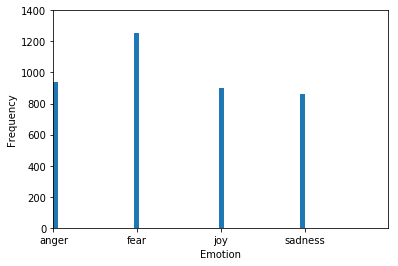

In [6]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 1400])
    plt.show()
histograma(emotions)

Preprocesing of Sentences

In [7]:
def decontracted(phrase):
    # specific
    '''phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)'''

    if phrase == "t":
        phrase = "not"
    elif phrase == "re":
        phrase = "are"
    elif phrase == "s":
        phrase = "is"
    elif phrase == "d":
        phrase = "would"
    elif phrase == "ve":
        phrase = "have"
    elif phrase == "m":
        phrase = "am"
    elif phrase == "ca":
        phrase = "can"
    elif phrase == "isn":
        phrase = "is"
    elif phrase == "aren":
        phrase = "are"
    elif phrase == "wouldn":
        phrase = "would"
    elif phrase == "don":
        phrase = "do"
    elif phrase == "wasn":
        phrase = "was"
    elif phrase == "weren":
        phrase = "were"

    # general
    '''phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)'''
    return phrase

In [8]:
def translator(user_string):
    user_string = user_string.lower()
    user_string = WordPunctTokenizer().tokenize(user_string)
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "TwitterDataset/slang.txt"
        # File Access mode [Read Mode]
        accessMode = "r"
        with open(fileName, accessMode) as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its Abbreviation in text file.
                    user_string[j] = row[1].lower()
            myCSVfile.close()
        j = j + 1
    return user_string

In [9]:
#----------------Cleanning Sentences--------------
lem = WordNetLemmatizer()
def clean_text(text, remove_stopwords=False):
    '''Clean the text, with the option to remove stopwords'''
    #Remove @user or http://...
    text = re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text) 

    # Translate OMG to Oh My God
    text = translator(text)
    #Decontracs
    for w in range (0,len(text)):
        text[w] = decontracted(text[w])

    # Convert words to lower case and split them
    #text = text.lower()#.split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    #Lematize && itertools Ejmp: looove to love
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    text = lem.lemmatize(text, "v")
    
    # Return a list of words
    return(text)


train_clean = []
for sentence in train.Sentence:
    train_clean.append(clean_text(sentence))

In [10]:
# Inspect the cleaned reviews
for i in range(3):
    print(sentences[i])
    print(train_clean[i])
    print()

How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##
how the fu k who the heck moved my fridge should i knock the landlord door angry mad

So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted 
so my indian uber driver just called someone the n word if i was not in a moving vehicle i would have jumped out disgusted

@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice
i asked for my parcel to be delivered to a pick up store not my address fuming poorcustomerservice



Les't determine the total and average number of words in each sentencesLes't determine the total and average number of words in each sentences

In [11]:
def maximum(sent):
    numWords = []
    for s in sent:
        counter = len(s)
        numWords.append(counter) 
    maxLengh = int(sum(numWords)/len(numWords))
    print("Average: ", maxLengh)
    return numWords,maxLengh
numWords,maxSeqLength = maximum(train_clean)

Average:  83


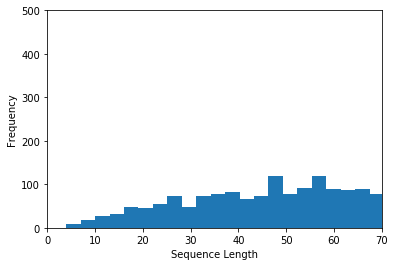

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
def histograma(numWords):
    plt.hist(numWords, 50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0, 70, 0, 500])
    plt.show()
histograma(numWords)

Converting each sentence into a vector and adding it into a matrix of 'ids'

In [13]:
def integerSenteces(sent,maximum):
    i = 0
    embbeding = 0
    matrix = np.zeros((len(sent), maximum)) #250 X 6 (numEjem X Maximun)
    for s in sent:
        vector = np.zeros((maximum), dtype='int32')
        s =  s.split()
        bound = maximum
        if len(s) < maximum:
            bound = len(s)    
        for token in range(0,bound): #No encuentra macu, porque la corta
            if s[token] not in wordsList:
                vector[token] = embbeding # ???
                #---print(s[token])
            else:
                vector[token] = (wordsList.index(s[token]))
                embbeding = vector[token]
        matrix[i] = (vector)
        i += 1
    return matrix

In [14]:
X = integerSenteces(train_clean,maxSeqLength) 
print("Sentences integer representation: ",(X.shape))
print("Sentences: ",len(train_clean))
print("Integer format: ",X[249])
print("Normal format: ",train_clean[249])

Sentences integer representation:  (3960, 83)
Sentences:  3960
Integer format:  [8.100e+01 4.300e+01 3.320e+02 5.960e+02 1.318e+03 3.800e+01 4.146e+03
 8.100e+01 1.170e+02 4.100e+01 1.190e+02 5.000e+00 1.200e+01 1.920e+02
 8.350e+02 4.300e+01 3.000e+01 1.920e+02 5.476e+03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Normal format:  you will never find someone who loved you like i did and that

In [15]:
def toClasses(emo):
    id_emo = []
    for e in emo:
        e = e.split()
        e = e[0]
        if e == 'joy':
            e = 1
        elif e == 'sadness':
            e = 2
        elif e == 'anger':
            e = 3
        elif e == 'fear':
            e = 4
            
        id_emo.append(e)
    return id_emo
emotions = toClasses(emotions)
print(emotions[0]," ",sentences[0])

3   How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##


Split the Data (stratify) into : Train && Test Sets

In [16]:
print("Sentences: ",len(X),"  Labels: ",len(emotions))
X_train, X_test, Y_train, Y_test = train_test_split(X, emotions, test_size=0.20, random_state=random.randrange(50), stratify=emotions)
print("X_train: ",len(X_train),"  Y_train: ",len(Y_train),"  X_test: ",len(X_test),"  Y_test: ",len(Y_test))

Sentences:  3960   Labels:  3960
X_train:  3168   Y_train:  3168   X_test:  792   Y_test:  792


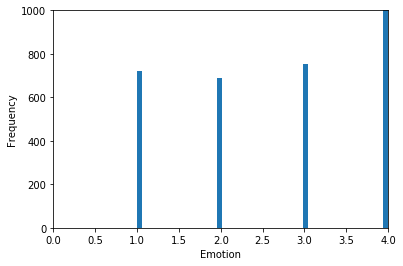

*****************


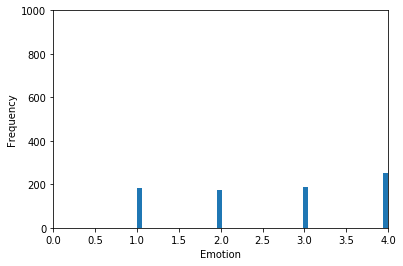

In [17]:
import matplotlib.pyplot as plt
import collections
%matplotlib inline
def histograma(emotion):
    #print(emotion)
    plt.hist(emotion, 50)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.axis([0, 4, 0, 1000])
    plt.show()
histograma(Y_train)
print("*****************")
histograma(Y_test)
#for i in range (0,len(X_train)):
 #   print(Y_train[i],"  ",X_train[i])

Converting the Labels into Onehot Vectors

In [18]:
def toLabels(emo):
    classes = 4
    Y = np.zeros((len(emo), classes)) #Num Ejemplos X 4 emociones
    for e in range(0,len(emo)):
        vector = np.zeros((classes))
        vector[(emo[e] % (classes + 1)) - 1] = 1 
        Y[e] = vector
        #print(emo[e],"---",vector)
    return Y
 
Y_train = toLabels(Y_train)
Y_test = toLabels(Y_test)

In [19]:
print("Y_train: ",Y_train.shape," Num Ejem X # clases")
print("X_train: ",X_train.shape," Num Ejem X Maximun Lengh")
print("Y_test: ",Y_test.shape," Num Ejem X # clases")
print("X_test: ",X_test.shape," Num Ejem X Maximun Lengh")

Y_train:  (3168, 4)  Num Ejem X # clases
X_train:  (3168, 83)  Num Ejem X Maximun Lengh
Y_test:  (792, 4)  Num Ejem X # clases
X_test:  (792, 83)  Num Ejem X Maximun Lengh


Test Dataset

anger   At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes
Labels:  3142 Sentences:  3142


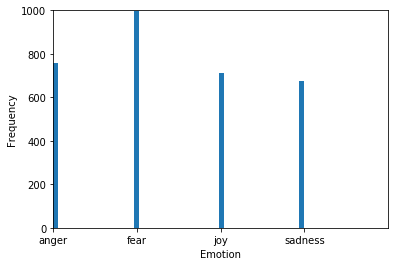

At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes
at the point today where if someone says something remotely kind to me a waterfall will burst out of my eyes

@CorningFootball  IT'S GAME DAY!!!!      T MINUS 14:30  #relentless
it is game day not minus  relentless

This game has pissed me off more than any other game this year. My blood is boiling! Time to turn it off! #STLCards
this game has pissed me off more than any other game this year my blood is boiling time to turn it off stlcards

Average:  83
Average:  83
Sentences integer representation:  (3142, 83)
Sentences:  3142
Integer format:  [1.8120e+03 4.0000e+00 1.4960e+03 8.3700e+02 9.6740e+03 2.2000e+01
 6.5400e+02 1.2000e+01 2.2135e+04 8.1000e+01 2.0000e+01 1.4000e+01
 4.8620e+03 4.0000e+00 1.6900e+02 5.1210e+03 2.2000e+01 6.9000e+01
 3.8140e+03 3.8140e+03 5.1210e+03 3.5910e+03 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0

In [20]:
#Importing Dataset
dataset = "TwitterDataset/Test/testDataset.txt"
test_sentences,test_emotions = extract(dataset)
print(test_emotions[0]," ",test_sentences[0])
print("Labels: ",len(test_emotions), "Sentences: ",len(test_sentences))

#Converting data to CVS
import csv
with open('TwitterDataset/Test/test.csv', mode='w', encoding='utf-8') as emo_file:
    emo_writer = csv.writer(emo_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    emo_writer.writerow(['Emotion', 'Sentence'])
    for i in range(0,len(test_emotions)):
        emo_writer.writerow([test_emotions[i],test_sentences[i]])

#Examinaiting the data
test = pd.read_csv("TwitterDataset/Test/test.csv", delimiter=",")
test.head()

histograma(test_emotions)

#Cleanning the data
test_clean = []
for sentence in test.Sentence:
    test_clean.append(clean_text(sentence))
    
# Inspect the cleaned reviews
for i in range(3):
    print(test_sentences[i])
    print(test_clean[i])
    print()
    
#Find the maximun sequence of words in test dataset
numWords,testmaxSeqLength = maximum(test_clean)
test_X = integerSenteces(test_clean,testmaxSeqLength)
print("Average: ",testmaxSeqLength)
print("Sentences integer representation: ",(test_X.shape))
print("Sentences: ",len(test_clean))
print("Integer format: ",test_X[249])
print("Normal format: ",test_clean[249])

#Transforming Labels From Happy to 1
test_emotions = toClasses(test_emotions)
print(test_emotions[0]," ",test_X[0])

#Transforming Labels from 1 to [1,0,0,0]
test_Y = toLabels(test_emotions)

print("Y_train: ",test_Y.shape," Num Ejem X # clases")
print("X_train: ",test_X.shape," Num Ejem X Maximun Lengh")

In [21]:
#Random X_test split
#x_train, y_train = train_test_split(test_X, test_Y, test_size=0.1, random_state=random.randrange(50), stratify=test_Y)
#Flata!!!

In [22]:
print("Y_train: ",test_Y.shape," Num Ejem X # clases")
print("X_train: ",test_X.shape," Num Ejem X Maximun Lengh")
#for i in range (0,len(x_test)):
 #   print(y_test[i])

Y_train:  (3142, 4)  Num Ejem X # clases
X_train:  (3142, 83)  Num Ejem X Maximun Lengh


RNN Model

In [23]:
def build_rnn(numClasses, maxSeqLength, numDimensions, batchSize, lstmUnits, dropout, learning_rate):
    '''Build the Recurrent Neural Network'''

    tf.reset_default_graph()

    # Declare placeholders we'll feed into the graph
    with tf.name_scope('inputs'):
        inputs = tf.placeholder(tf.int32, [None, maxSeqLength],name='inputs')
        
    
    with tf.name_scope('labels'):
        labels = tf.placeholder(tf.float32, [None, numClasses],name='labels')
    

    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    # Create the embeddings
    with tf.name_scope("embeddings"):
        data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
        data = tf.nn.embedding_lookup(wordVectors,inputs)

    # Build the RNN layers
    with tf.name_scope("RNN_layers"):
        lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
       
    # Set the initial state
    with tf.name_scope("RNN_init_state"):
        initial_state = lstmCell.zero_state(batchSize, tf.float32)

    # Run the data through the RNN layers
    with tf.name_scope("RNN_forward"):  
        value, final_state = tf.nn.dynamic_rnn(lstmCell, data, initial_state=initial_state)
     
    # Create the fully connected layers
    with tf.name_scope("fully_connected"):
        
        # Initialize the weights and biases
        weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
        bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
        value = tf.transpose(value, [1, 0, 2])
        last = tf.gather(value, int(value.get_shape()[0]) - 1)
       
        
    # Make the predictions
    with tf.name_scope('prediction'):
        prediction = (tf.matmul(last, weight) + bias)
        tf.summary.histogram('prediction', prediction)
    
    # Calculate the cost
    with tf.name_scope('cost'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
        tf.summary.scalar('cost', cost)
        
    
    # Train the model
    with tf.name_scope('train'):    
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Determine the accuracy
    with tf.name_scope("accuracy"):
        
        correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))       
        tf.summary.scalar('accuracy', accuracy)
        
    
    # Merge all of the summaries
    merged = tf.summary.merge_all()    

    # Export the nodes 
    export_nodes = ['inputs', 'labels','keep_prob', 'initial_state', 'final_state', 'accuracy',
                    'prediction', 'cost', 'optimizer', 'merged']
    Graph = namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

Trainning && Validation Cycles

In [24]:
def train(model, epochs, log_string):
    '''Train the RNN'''
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        valid_loss_summary = []
        
        # Metrics Presicion, recall and F1 measure
        val_pre = []
        val_recall = []
        val_f1 = []
        
        # Keep track of which batch iteration is being trained
        iteration = 0

        print()
        print("Training Model: {}".format(log_string))

        train_writer = tf.summary.FileWriter('./logs/3/train/{}'.format(log_string), sess.graph)
        valid_writer = tf.summary.FileWriter('./logs/3/valid/{}'.format(log_string))

        for e in range(epochs):
            state = sess.run(model.initial_state)
            
            # Record progress with each epoch
            train_loss = []
            train_acc = []
            val_acc = []
            val_loss = []
            
            #Create X groups of (50,6) Labels && (50,maximum) Examples
            numEjemplos = 3168  
            total_batch = int(numEjemplos/batchSize)
            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(Y_train, total_batch)

            #Train Cycle
            with tqdm(total=len(X_train)) as pbar: #Barra de progreso !!!
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: dropout,
                            model.initial_state: state}
                    summary, loss, acc, state, _ = sess.run([model.merged, 
                                                             model.cost, 
                                                             model.accuracy, 
                                                             model.final_state, 
                                                             model.optimizer], 
                                                            feed_dict=feed)

                    # Record the loss and accuracy of each training batch
                    train_loss.append(loss)
                    train_acc.append(acc)
                    
                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)
                    
                    iteration += 1
                    pbar.update(batchSize)
            
            # Average the training loss and accuracy of each epoch
            avg_train_loss = np.mean(train_loss)
            avg_train_acc = np.mean(train_acc) 

            #Create X train batchs of batchSize
            numEjemplos = 792  
            total_batch = int(numEjemplos/batchSize)
            
            X_batches = np.array_split(X_test, total_batch)
            Y_batches = np.array_split(Y_test, total_batch)
            
            if e < 88:
            # Print the progress of each epoch
                print("Epoch: {}/{}".format(e, epochs),
                        "Train Loss: {:.3f}".format(avg_train_loss),
                        "Train Acc: {:.3f}".format(avg_train_acc))

                
            #Valid Cycle : Solo Valid, en las dos últimas iteraciones
            else:
                val_state = sess.run(model.initial_state)
                with tqdm(total=len(X_test)) as pbar:
                    for i in range(total_batch):
                        batch_x, batch_y = X_batches[i], Y_batches[i]
                        feed = {model.inputs: batch_x,
                                model.labels: batch_y,
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_loss, batch_acc, val_state, batch_pre = sess.run([model.merged, 
                                                                              model.cost, 
                                                                              model.accuracy, 
                                                                              model.final_state,
                                                                              model.prediction], 
                                                                             feed_dict=feed)


                        #Converting predictions to np.array 
                        y_pred = tf.argmax(batch_pre , 1).eval({model.inputs: batch_x, model.labels: batch_y})
                        y_true = (tf.argmax(batch_y , 1).eval()) 
                        precision = precision_score(y_true, y_pred, average=None)
                        recall = recall_score(y_true, y_pred, average=None)
                        f1 = f1_score(y_true, y_pred, average=None)

                        # Record the validation loss and accuracy of each epoch
                        val_loss.append(batch_loss)
                        val_acc.append(batch_acc)
                        val_pre.append(precision)
                        val_recall.append(recall)
                        val_f1.append(f1)
                        pbar.update(batchSize)



                # Average the validation loss and accuracy of each epoch
                avg_valid_loss = np.mean(val_loss)    
                avg_valid_acc = np.mean(val_acc)
                valid_loss_summary.append(avg_valid_loss)
                avg_pre = np.mean(val_pre)
                avg_recall = np.mean(val_recall)
                avg_f1 = np.mean(val_f1)

                # Record the validation data's progress
                valid_writer.add_summary(summary, iteration)


                print("Epoch: {}/{}".format(e, epochs),
                "Train Loss: {:.3f}".format(avg_train_loss),
                "Train Acc: {:.3f}".format(avg_train_acc),
                "Valid Loss: {:.3f}".format(avg_valid_loss),
                "Valid Acc: {:.3f}".format(avg_valid_acc),
                "Valid Pre: {:.3f}".format(avg_pre),
                "Valid Reca: {:.3f}".format(avg_recall),
                "Valid F1: {:.3f}".format(avg_f1))
                
                class_names = ["Hapinnes","Sadness","Anger","Fear"]
                print(classification_report(y_true, y_pred, target_names=class_names))
                
            checkpoint = "C:/Users/UX310UQ/Desktop/CheckPoints/sentiment_{}.ckpt".format(log_string)
            saver.save(sess, checkpoint)

Declarando placeholders para los labels (6 emotions) && data imput

In [25]:
# The default parameters of the model
numDimensions = 300 
batchSize = 88 #Tiene que ser multiplo del NumEjem
lstmUnits = 64
numClasses = 4
dropout = 0.5
learning_rate = 0.001
epochs = 10

In [ ]:
log_string = 'ru={},fcl={},fcu={}'.format(7,10,96)
model = build_rnn(numClasses = numClasses,
                              maxSeqLength=maxSeqLength,
                              numDimensions=numDimensions,
                              batchSize = batchSize,
                              lstmUnits = lstmUnits,
                              dropout = dropout,
                              learning_rate = learning_rate)       
train(model, epochs, log_string)


Training Model: ru=7,fcl=10,fcu=96


100%|██████████| 3168/3168 [00:06<00:00, 669.59it/s]


Epoch: 0/10 Train Loss: 1.378 Train Acc: 0.316


100%|██████████| 3168/3168 [00:04<00:00, 788.73it/s]


Epoch: 1/10 Train Loss: 1.378 Train Acc: 0.314


100%|██████████| 3168/3168 [00:04<00:00, 805.09it/s]


Epoch: 2/10 Train Loss: 1.377 Train Acc: 0.317


100%|██████████| 3168/3168 [00:04<00:00, 790.29it/s]


Epoch: 3/10 Train Loss: 1.377 Train Acc: 0.317


100%|██████████| 3168/3168 [00:04<00:00, 683.92it/s]


Epoch: 4/10 Train Loss: 1.377 Train Acc: 0.318


100%|██████████| 3168/3168 [00:04<00:00, 793.04it/s]


Epoch: 5/10 Train Loss: 1.377 Train Acc: 0.318


100%|██████████| 3168/3168 [00:04<00:00, 706.37it/s]


Epoch: 6/10 Train Loss: 1.376 Train Acc: 0.318


100%|██████████| 3168/3168 [00:06<00:00, 731.54it/s]


Epoch: 7/10 Train Loss: 1.377 Train Acc: 0.317


 75%|███████▌  | 2376/3168 [00:03<00:01, 637.26it/s]

In [ ]:
Hacer ultimo chekpoint . en base a F1 
Probar con Stop words y otras mod.
Limpiar #poorattention
@@ estas haciendo valid con batch pqueño , no con todo el gigante, pero no importan en el test se hace asi
pondras 

In [161]:
batchSize = 3141 #Habra solo 1 batchs de  3141 ejempos

In [193]:
def make_predictions(checkpoint):
    '''Predict the sentiment of the testing data'''
    
    # Record all of the predictions
    all_preds = []

    model = build_rnn(numClasses = numClasses,
                                  maxSeqLength=testmaxSeqLength,
                                  numDimensions=numDimensions,
                                  batchSize = batchSize,
                                  lstmUnits = lstmUnits,
                                  dropout = dropout,
                                  learning_rate = learning_rate)  
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        # Load the model
        saver.restore(sess, checkpoint)
        test_state = sess.run(model.initial_state)
        
        #numEjemplos = 3141  
        #total_batch = int(numEjemplos/batchSize)
            
        #X_batches = np.array_split(X_test, total_batch)
        #Y_batches = np.array_split(Y_test, total_batch)
        '''print("Y_train: ",test_Y.shape," Num Ejem X # clases")
        print("X_train: ",test_X.shape," Num Ejem X Maximun Lengh")
        
        X_batches = test_X[:88]
        Y_batches = test_Y[:88]
        
        print("Y_batches: ",Y_batches.shape," Num Ejem X # clases")
        print("X_batches: ",X_batches.shape," Num Ejem X Maximun Lengh")
        
        feed = {model.inputs: X_batches,
                    model.keep_prob: 1,
                    model.initial_state: test_state}
        
        predictions = sess.run(model.prediction, feed_dict=feed)
        
        Y = (tf.argmax(Y_batches , 1).eval()) 
        
        Y_pred = tf.argmax(predictions , 1).eval()
        
        for p in range (0,len(Y_pred)):
            print(Y[p]," ",Y_pred[p])
            all_preds.append((Y_pred))'''
        
            
        '''for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            feed = {model.inputs: batch_x,
                    model.keep_prob: 1,
                    model.initial_state: test_state}
            predictions = sess.run(model.prediction, feed_dict=feed)
            Y = (tf.argmax(batch_y , 1).eval()) 
            Y_pred = tf.argmax(predictions , 1).eval()
            for p in range (0,len(Y_pred)):
                print(Y[p]," ",Y_pred[p])
                all_preds.append((Y_pred))'''
                
                
    return all_preds

In [194]:
checkpoint1 = "C:/Users/UX310UQ/Desktop/CheckPoints/sentiment_ru=7,fcl=10,fcu=96.ckpt"

In [195]:
# Make predictions using the best 3 models
predictions1 = make_predictions(checkpoint1)

INFO:tensorflow:Restoring parameters from C:/Users/UX310UQ/Desktop/CheckPoints/sentiment_ru=7,fcl=10,fcu=96.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [3141,83,300] rhs shape= [88,83,300]
	 [[Node: save/Assign = Assign[T=DT_FLOAT, _class=["loc:@embeddings/Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embeddings/Variable, save/RestoreV2)]]

Caused by op 'save/Assign', defined at:
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-195-5f87938c8171>", line 2, in <module>
    predictions1 = make_predictions(checkpoint1)
  File "<ipython-input-193-cb3d9b33c9cb>", line 16, in make_predictions
    saver = tf.train.Saver()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 1338, in __init__
    self.build()
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 494, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\training\saver.py", line 185, in restore
    self.op.get_shape().is_fully_defined())
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\ops\state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 59, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\UX310UQ\Anaconda3\envs\IaTopicos\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [3141,83,300] rhs shape= [88,83,300]
	 [[Node: save/Assign = Assign[T=DT_FLOAT, _class=["loc:@embeddings/Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embeddings/Variable, save/RestoreV2)]]


Tensorboar

In [76]:
import datetime
def board(sess):
    tf.summary.scalar('Loss', loss)
    tf.summary.scalar('Accuracy', accuracy)
    tf.summary.histogram("Histogrma/hAccu", accuracy)
    merged = tf.summary.merge_all()
    logdir = "board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    return merged,writer

Confusion Matrix Plot

In [72]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [84]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  
print('Balance',Counter(emotions))

Balance Counter({4: 1257, 3: 941, 1: 902, 2: 860})


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
#Banlancea ADASYN
X_balance, Y_balance = ADASYN().fit_sample(X,emotions)
print('Balance',Counter(Y_balance))

In [48]:
print(X_balance.shape," ",Y_balance.shape)
print(len(X)," ",len(emotion))

(7836, 15)   (7836,)
3695   3695


In [49]:
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_balance, Y_balance, test_size=0.13, random_state=random.randrange(50), stratify=Y_balance)
print("X_train: ",len(X_train_b),"  Y_train: ",len(Y_train_b),"  X_test: ",len(X_test_b),"  Y_test: ",len(Y_test_b))

X_train:  6817   Y_train:  6817   X_test:  1019   Y_test:  1019


In [50]:
Y_train_b = toLabels(Y_train_b)
Y_test_b = toLabels(Y_test_b)

Otro Modelo: Solo balanceamos Trainset

In [ ]:
#Averogua ottros modelos
#Cambie el keep_drop
#Cambia learning rate
#Cambie num unidades 128?
#Prueba con tu modelo

In [ ]:
def train(model, epochs, log_string):
    '''Train the RNN'''

    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Used to determine when to stop the training early
        valid_loss_summary = []
        
        # Metrics Presicion, recall and F1 measure
        val_pre = []
        val_recall = []
        val_f1 = []
        
        # Keep track of which batch iteration is being trained
        iteration = 0

        print()
        print("Training Model: {}".format(log_string))

        train_writer = tf.summary.FileWriter('./logs/3/train/{}'.format(log_string), sess.graph)
        valid_writer = tf.summary.FileWriter('./logs/3/valid/{}'.format(log_string))

        for e in range(epochs):
            state = sess.run(model.initial_state)
            
            # Record progress with each epoch
            train_loss = []
            train_acc = []
            val_acc = []
            val_loss = []
            
            #Create X groups of (50,6) Labels && (50,maximum) Examples
            numEjemplos = 3168  
            total_batch = int(numEjemplos/batchSize)
            X_batches = np.array_split(X_train, total_batch)
            Y_batches = np.array_split(Y_train, total_batch)

            #Train Cycle
            with tqdm(total=len(X_train)) as pbar: #Barra de progreso !!!
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: dropout,
                            model.initial_state: state}
                    summary, loss, acc, state, _ = sess.run([model.merged, 
                                                             model.cost, 
                                                             model.accuracy, 
                                                             model.final_state, 
                                                             model.optimizer], 
                                                            feed_dict=feed)

                    # Record the loss and accuracy of each training batch
                    train_loss.append(loss)
                    train_acc.append(acc)
                    
                    # Record the progress of training
                    train_writer.add_summary(summary, iteration)
                    
                    iteration += 1
                    pbar.update(batchSize)
            
            # Average the training loss and accuracy of each epoch
            avg_train_loss = np.mean(train_loss)
            avg_train_acc = np.mean(train_acc) 

            #Create X train batchs of batchSize
            numEjemplos = 792  
            total_batch = int(numEjemplos/batchSize)
            
            X_batches = np.array_split(X_test, total_batch)
            Y_batches = np.array_split(Y_test, total_batch)
                
            #Valid Cycle
            val_state = sess.run(model.initial_state)
            with tqdm(total=len(X_test)) as pbar:
                for i in range(total_batch):
                    batch_x, batch_y = X_batches[i], Y_batches[i]
                    feed = {model.inputs: batch_x,
                            model.labels: batch_y,
                            model.keep_prob: 1,
                            model.initial_state: val_state}
                    summary, batch_loss, batch_acc, val_state, batch_pre = sess.run([model.merged, 
                                                                          model.cost, 
                                                                          model.accuracy, 
                                                                          model.final_state,
                                                                          model.prediction], 
                                                                         feed_dict=feed)
                    
                    
                    #Converting predictions to np.array 
                    y_pred = tf.argmax(batch_pre , 1).eval({model.inputs: batch_x, model.labels: batch_y})
                    y_true = (tf.argmax(batch_y , 1).eval()) 
                    precision = precision_score(y_true, y_pred, average=None)
                    recall = recall_score(y_true, y_pred, average=None)
                    f1 = f1_score(y_true, y_pred, average=None)
                    
                    # Record the validation loss and accuracy of each epoch
                    val_loss.append(batch_loss)
                    val_acc.append(batch_acc)
                    val_pre.append(precision)
                    val_recall.append(recall)
                    val_f1.append(f1)
                    pbar.update(batchSize)
                    
                    
            
            # Average the validation loss and accuracy of each epoch
            avg_valid_loss = np.mean(val_loss)    
            avg_valid_acc = np.mean(val_acc)
            valid_loss_summary.append(avg_valid_loss)
            avg_pre = np.mean(val_pre)
            avg_recall = np.mean(val_recall)
            avg_f1 = np.mean(val_f1)
            
            # Record the validation data's progress
            valid_writer.add_summary(summary, iteration)

            # Print the progress of each epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train Loss: {:.3f}".format(avg_train_loss),
                  "Train Acc: {:.3f}".format(avg_train_acc),
                  "Valid Loss: {:.3f}".format(avg_valid_loss),
                  "Valid Acc: {:.3f}".format(avg_valid_acc))

            if e > 148:
                print("Epoch: {}/{}".format(e, epochs),
                "Train Loss: {:.3f}".format(avg_train_loss),
                "Train Acc: {:.3f}".format(avg_train_acc),
                "Valid Loss: {:.3f}".format(avg_valid_loss),
                "Valid Acc: {:.3f}".format(avg_valid_acc),
                "Valid Pre: {:.3f}".format(avg_pre),
                "Valid Reca: {:.3f}".format(avg_recall),
                "Valid F1: {:.3f}".format(avg_f1))
                
                class_names = ["Hapinnes","Sadness","Anger","Fear"]
                print(classification_report(y_true, y_pred, target_names=class_names))
                
            # Stop training if the validation loss does not decrease after 3 epochs
            if avg_valid_loss > min(valid_loss_summary):
                print("No Improvement.")
                #-----stop_early += 1
                if stop_early == 3:
                    break   
            
            # Reset stop_early if the validation loss finds a new low
            # Save a checkpoint of the model
            else:
                print("New Record!")
                stop_early = 0
                checkpoint = "C:/Users/UX310UQ/Desktop/CheckPoints/sentiment_{}.ckpt".format(log_string)
                saver.save(sess, checkpoint)